<a href="https://colab.research.google.com/github/MarinaNasser/Medical-Image-Processing-/blob/Version-5/heart_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [ ]:
# ============================================================================
# STEP 1: ACDC DATA LOADER - LOAD REAL NIfTI DATA
# ============================================================================

class ACDCDataLoader:
    def __init__(self, data_path):
        self.data_path = data_path
        self.class_names = {
            0: 'background',
            1: 'right_ventricle',
            2: 'myocardium',
            3: 'left_ventricle'
        }

    def load_acdc_data(self):
        """Load real ACDC2017 dataset from BMP files"""
        print(f"Loading ACDC data from: {self.data_path}")

        images = []
        masks = []
        patient_ids = []

        # Get images and gt folders
        images_dir = os.path.join(self.data_path, 'images')
        gt_dir = os.path.join(self.data_path, 'gt')

        if not os.path.exists(images_dir) or not os.path.exists(gt_dir):
            raise FileNotFoundError(f"Expected 'images' and 'gt' folders in {self.data_path}")

        # Get all image files (BMP format)
        image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.bmp')])

        print(f"Found {len(image_files)} image files")

        for img_file in tqdm(image_files):
            img_path = os.path.join(images_dir, img_file)
            # GT file has same name as image file
            gt_path = os.path.join(gt_dir, img_file)

            if os.path.exists(gt_path):
                img, mask = self._load_bmp_pair(img_path, gt_path)
                if img is not None and mask is not None:
                    images.append(img)
                    masks.append(mask)
                    patient_ids.append(os.path.splitext(img_file)[0])

        print(f"Loaded {len(images)} images")

        return np.array(images), np.array(masks), patient_ids

    def _load_bmp_pair(self, img_path, mask_path):
        """Load BMP image and mask, normalize image"""
        try:
            # Load BMP files using OpenCV
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if img is None or mask is None:
                print(f"Failed to load {img_path} or {mask_path}")
                return None, None

            # Resize to 256x256 for consistency
            img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

            # Convert to float
            img = img.astype(np.float32)
            mask = mask.astype(np.uint8)

            # Normalize image to 0-1 range
            img_min = img.min()
            img_max = img.max()
            if img_max > img_min:
                img = (img - img_min) / (img_max - img_min)
            else:
                img = np.zeros_like(img)

            # IMPORTANT: Ensure mask has correct integer labels (0, 1, 2, 3)
            # The mask pixel values should be: 0, 85, 170, 255 (which represent 0, 1, 2, 3)
            # Convert to class labels
            unique_vals = np.unique(mask)

            if len(unique_vals) > 0 and unique_vals.max() > 3:
                # If pixel values are 0, 85, 170, 255, convert to 0, 1, 2, 3
                mask_converted = np.zeros_like(mask)
                for i, val in enumerate(sorted(unique_vals)):
                    mask_converted[mask == val] = i
                mask = mask_converted

            mask = np.round(mask).astype(np.uint8)

            # Add channel dimension to image
            img = img.reshape(256, 256, 1)

            return img, mask

        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            return None, None

In [ ]:

# ============================================================================
# STEP 2: LOAD DATA
# ============================================================================

ACDC_TRAIN_PATH = "./acdc2017/train"
ACDC_VAL_PATH = "./acdc2017/valid"
ACDC_TEST_PATH = "./acdc2017/test"

# Check which datasets exist
datasets_to_load = []
if os.path.exists(ACDC_TRAIN_PATH):
    datasets_to_load.append(('train', ACDC_TRAIN_PATH))
if os.path.exists(ACDC_VAL_PATH):
    datasets_to_load.append(('valid', ACDC_VAL_PATH))
if os.path.exists(ACDC_TEST_PATH):
    datasets_to_load.append(('test', ACDC_TEST_PATH))

if not datasets_to_load:
    print("ERROR: ACDC data not found!")
    print("Expected structure:")
    print("  acdc2017/")
    print("  ├── train/")
    print("  │   ├── images/")
    print("  │   └── gt/")
    print("  ├── valid/")
    print("  │   ├── images/")
    print("  │   └── gt/")
    print("  └── test/")
    print("      ├── images/")
    print("      └── gt/")
else:
    # Load all available datasets (train, valid, test)
    datasets = {}

    for dataset_name, dataset_path in datasets_to_load:
        print(f"\n{'='*60}")
        print(f"Loading {dataset_name.upper()} dataset...")
        print(f"{'='*60}")

        data_loader = ACDCDataLoader(dataset_path)
        X, y, patient_ids = data_loader.load_acdc_data()

        datasets[dataset_name] = {
            'X': X,
            'y': y,
            'patient_ids': patient_ids
        }

        print(f"  {dataset_name}: {len(X)} samples loaded")

    # Use pre-split datasets
    X_train = datasets['train']['X'] if 'train' in datasets else None
    y_train = datasets['train']['y'] if 'train' in datasets else None

    X_val = datasets['valid']['X'] if 'valid' in datasets else None
    y_val = datasets['valid']['y'] if 'valid' in datasets else None

    X_test = datasets['test']['X'] if 'test' in datasets else None
    y_test = datasets['test']['y'] if 'test' in datasets else None

    if X_train is None or X_val is None or X_test is None:
        raise ValueError("Missing train, valid, or test datasets!")

    print(f"\n{'='*60}")
    print(f"DATA LOADED (PRE-SPLIT)")
    print(f"{'='*60}")
    print(f"Training samples: {len(X_train):,}")
    print(f"Validation samples: {len(X_val):,}")
    print(f"Test samples: {len(X_test):,}")
    print(f"Total: {len(X_train) + len(X_val) + len(X_test):,}")
    print(f"\nImage shape: {X_train.shape}, Mask shape: {y_train.shape}")
    print(f"Image range: [{X_train.min():.3f}, {X_train.max():.3f}]")
    print(f"Mask unique values: {np.unique(y_train)}")



Loading TRAIN dataset...
Loading ACDC data from: ./acdc2017/train
Found 1282 image files


100%|██████████| 1282/1282 [00:00<00:00, 2362.48it/s]


Loaded 1282 images
  train: 1282 samples loaded

Loading VALID dataset...
Loading ACDC data from: ./acdc2017/valid
Found 172 image files


100%|██████████| 172/172 [00:00<00:00, 2556.92it/s]


Loaded 172 images
  valid: 172 samples loaded

Loading TEST dataset...
Loading ACDC data from: ./acdc2017/test
Found 448 image files


100%|██████████| 448/448 [00:00<00:00, 2630.69it/s]


Loaded 448 images
  test: 448 samples loaded

DATA LOADED (PRE-SPLIT)
Training samples: 1,282
Validation samples: 172
Test samples: 448
Total: 1,902

Image shape: (1282, 256, 256, 1), Mask shape: (1282, 256, 256)
Image range: [0.000, 1.000]
Mask unique values: [0 1 2 3]


In [ ]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
        inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
        s = inputs

        # Contraction path
        c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
        c1 = Dropout(0.1)(c1)
        c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
        p1 = MaxPooling2D((2, 2))(c1)

        c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
        c2 = Dropout(0.1)(c2)
        c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
        p2 = MaxPooling2D((2, 2))(c2)

        c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
        c3 = Dropout(0.2)(c3)
        c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
        p3 = MaxPooling2D((2, 2))(c3)

        c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
        c4 = Dropout(0.2)(c4)
        c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
        p4 = MaxPooling2D(pool_size=(2, 2))(c4)

        c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
        c5 = Dropout(0.3)(c5)
        c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

        # Expansive path
        u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
        c6 = Dropout(0.2)(c6)
        c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

        u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
        c7 = Dropout(0.2)(c7)
        c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

        u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
        c8 = Dropout(0.1)(c8)
        c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

        u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
        u9 = concatenate([u9, c1], axis=3)
        c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
        c9 = Dropout(0.1)(c9)
        c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

        outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

        model = Model(inputs=[inputs], outputs=[outputs])
        return model

print("\nBuilding U-Net model...")
model = multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1)



Building U-Net model...


In [ ]:
# Custom Dice coefficient
def sparse_dice_coefficient(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, depth=4)
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


In [ ]:
model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', sparse_dice_coefficient]
    )

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_19[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128, 128,  │          0 │ conv2d_21[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64, 64,    │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 32, 32,    │          0 │ conv2d_25[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_12[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0] 

 Total params: 1,940,868 (7.40 MB)

 Trainable params: 1,940,868 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
BATCH_SIZE = 8
EPOCHS = 50

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001,
        mode='min'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),
    ModelCheckpoint(
        './best_cardiac_model.h5',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    ),
    tf.keras.callbacks.CSVLogger('./training_log.csv', append=True)
]


In [ ]:
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {len(X_train) // BATCH_SIZE}")

try:
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1,
        shuffle=True
    )
    print(f"\n✅ Training completed!")
except Exception as e:
    print(f"\n❌ Training failed with error: {e}")
    print("\nTroubleshooting:")
    print("1. Try reducing batch size (e.g., 4 or 2)")
    print("2. Try using CPU: Uncomment os.environ['CUDA_VISIBLE_DEVICES'] = '-1'")
    print("3. Try reducing image size or number of samples")
    print("4. Clear GPU cache: tf.keras.backend.clear_session()")

    # Try to clear and retry with smaller batch size
    tf.keras.backend.clear_session()
    print("\nRetrying with smaller batch size (4)...")
    BATCH_SIZE = 4

    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1,
        shuffle=True
    )
    print(f"\n✅ Training completed with batch size {BATCH_SIZE}!")


Training data shape: (1282, 256, 256, 1)
Validation data shape: (172, 256, 256, 1)
Batch size: 8
Steps per epoch: 160
Epoch 1/50


2025-11-07 22:48:35.249582: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6824 - loss: 0.8507 - sparse_dice_coefficient: 0.5473

2025-11-07 22:48:40.727082: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6835 - loss: 0.8483 - sparse_dice_coefficient: 0.5486

2025-11-07 22:48:43.984316: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-11-07 22:48:44.470414: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



Epoch 1: val_loss improved from None to 0.22667, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8641 - loss: 0.4673 - sparse_dice_coefficient: 0.7645 - val_accuracy: 0.9683 - val_loss: 0.2267 - val_sparse_dice_coefficient: 0.8478 - learning_rate: 1.0000e-04
Epoch 2/50
157/161 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9622 - loss: 0.1354 - sparse_dice_coefficient: 0.9380
Epoch 2: val_loss improved from 0.22667 to 0.16693, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9627 - loss: 0.1240 - sparse_dice_coefficient: 0.9421 - val_accuracy: 0.9683 - val_loss: 0.1669 - val_sparse_dice_coefficient: 0.8907 - learning_rate: 1.0000e-04
Epoch 3/50
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9633 - loss: 0.1043 - sparse_dice_coefficient: 0.9494
Epoch 3: val_loss improved from 0.16693 to 0.11808, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9647 - loss: 0.1007 - sparse_dice_coefficient: 0.9511 - val_accuracy: 0.9654 - val_loss: 0.1181 - val_sparse_dice_coefficient: 0.9261 - learning_rate: 1.0000e-04
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9687 - loss: 0.0885 - sparse_dice_coefficient: 0.9566
Epoch 4: val_loss improved from 0.11808 to 0.09415, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9692 - loss: 0.0873 - sparse_dice_coefficient: 0.9570 - val_accuracy: 0.9707 - val_loss: 0.0941 - val_sparse_dice_coefficient: 0.9433 - learning_rate: 1.0000e-04
Epoch 5/50
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9705 - loss: 0.0818 - sparse_dice_coefficient: 0.9597
Epoch 5: val_loss did not improve from 0.09415
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9709 - loss: 0.0790 - sparse_dice_coefficient: 0.9606 - val_accuracy: 0.9681 - val_loss: 0.1097 - val_sparse_dice_coefficient: 0.9329 - learning_rate: 1.0000e-04
Epoch 6/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9723 - loss: 0.0725 - sparse_dice_coefficient: 0.9632
Epoch 6: val_loss did not improve from 0.09415
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9721 - loss: 0.0718 - sparse_dice_coefficient: 0.9635 - val_accuracy: 0.9655 - val_loss: 0.1220 - val_sparse_dice_coefficient: 0.9271 - learning_rate: 1.0000e-04
Epoch 7/50

161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9730 - loss: 0.0664 - sparse_dice_coefficient: 0.9658 - val_accuracy: 0.9721 - val_loss: 0.0814 - val_sparse_dice_coefficient: 0.9525 - learning_rate: 1.0000e-04
Epoch 8/50
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9732 - loss: 0.0642 - sparse_dice_coefficient: 0.9667
Epoch 8: val_loss improved from 0.08137 to 0.06598, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9741 - loss: 0.0609 - sparse_dice_coefficient: 0.9681 - val_accuracy: 0.9747 - val_loss: 0.0660 - val_sparse_dice_coefficient: 0.9613 - learning_rate: 1.0000e-04
Epoch 9/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9759 - loss: 0.0555 - sparse_dice_coefficient: 0.9703
Epoch 9: val_loss did not improve from 0.06598
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9763 - loss: 0.0551 - sparse_dice_coefficient: 0.9702 - val_accuracy: 0.9742 - val_loss: 0.0677 - val_sparse_dice_coefficient: 0.9601 - learning_rate: 1.0000e-04
Epoch 10/50
157/161 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9780 - loss: 0.0516 - sparse_dice_coefficient: 0.9719
Epoch 10: val_loss improved from 0.06598 to 0.05505, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9791 - loss: 0.0493 - sparse_dice_coefficient: 0.9731 - val_accuracy: 0.9785 - val_loss: 0.0550 - val_sparse_dice_coefficient: 0.9669 - learning_rate: 1.0000e-04
Epoch 11/50
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9807 - loss: 0.0489 - sparse_dice_coefficient: 0.9739
Epoch 11: val_loss did not improve from 0.05505
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9810 - loss: 0.0483 - sparse_dice_coefficient: 0.9738 - val_accuracy: 0.9754 - val_loss: 0.0669 - val_sparse_dice_coefficient: 0.9583 - learning_rate: 1.0000e-04
Epoch 12/50
157/161 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9833 - loss: 0.0442 - sparse_dice_coefficient: 0.9755
Epoch 12: val_loss did not improve from 0.05505
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9840 - loss: 0.0434 - sparse_dice_coefficient: 0.9762 - val_accuracy: 0.9718 - val_loss: 0.0668 - val_sparse_dice_coefficient: 0.9604 - learning_rate: 1.0000e-04
Epoch 

161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9848 - loss: 0.0420 - sparse_dice_coefficient: 0.9771 - val_accuracy: 0.9803 - val_loss: 0.0506 - val_sparse_dice_coefficient: 0.9713 - learning_rate: 1.0000e-04
Epoch 14/50
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9855 - loss: 0.0401 - sparse_dice_coefficient: 0.9783
Epoch 14: val_loss did not improve from 0.05063
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9858 - loss: 0.0390 - sparse_dice_coefficient: 0.9788 - val_accuracy: 0.9728 - val_loss: 0.0675 - val_sparse_dice_coefficient: 0.9633 - learning_rate: 1.0000e-04
Epoch 15/50
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9869 - loss: 0.0363 - sparse_dice_coefficient: 0.9800
Epoch 15: val_loss did not improve from 0.05063
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9870 - loss: 0.0360 - sparse_dice_coefficient: 0.9804 - val_accuracy: 0.9792 - val_loss: 0.0538 - val_sparse_dice_coefficient: 0.9685 - learning_rate: 1.0000e-04
Epoch 

161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9874 - loss: 0.0349 - sparse_dice_coefficient: 0.9810 - val_accuracy: 0.9841 - val_loss: 0.0415 - val_sparse_dice_coefficient: 0.9775 - learning_rate: 1.0000e-04
Epoch 17/50
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9877 - loss: 0.0340 - sparse_dice_coefficient: 0.9820
Epoch 17: val_loss did not improve from 0.04151
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9881 - loss: 0.0328 - sparse_dice_coefficient: 0.9824 - val_accuracy: 0.9790 - val_loss: 0.0556 - val_sparse_dice_coefficient: 0.9687 - learning_rate: 1.0000e-04
Epoch 18/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9880 - loss: 0.0327 - sparse_dice_coefficient: 0.9822
Epoch 18: val_loss did not improve from 0.04151
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9886 - loss: 0.0314 - sparse_dice_coefficient: 0.9830 - val_accuracy: 0.9835 - val_loss: 0.0431 - val_sparse_dice_coefficient: 0.9765 - learning_rate: 1.0000e-04
Epoch 

161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9892 - loss: 0.0294 - sparse_dice_coefficient: 0.9841 - val_accuracy: 0.9848 - val_loss: 0.0407 - val_sparse_dice_coefficient: 0.9776 - learning_rate: 1.0000e-04
Epoch 20/50
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9896 - loss: 0.0286 - sparse_dice_coefficient: 0.9846
Epoch 20: val_loss improved from 0.04065 to 0.03406, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9893 - loss: 0.0296 - sparse_dice_coefficient: 0.9842 - val_accuracy: 0.9871 - val_loss: 0.0341 - val_sparse_dice_coefficient: 0.9805 - learning_rate: 1.0000e-04
Epoch 21/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9897 - loss: 0.0280 - sparse_dice_coefficient: 0.9847
Epoch 21: val_loss did not improve from 0.03406
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9899 - loss: 0.0275 - sparse_dice_coefficient: 0.9851 - val_accuracy: 0.9831 - val_loss: 0.0454 - val_sparse_dice_coefficient: 0.9753 - learning_rate: 1.0000e-04
Epoch 22/50
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9899 - loss: 0.0274 - sparse_dice_coefficient: 0.9853
Epoch 22: val_loss improved from 0.03406 to 0.03150, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9901 - loss: 0.0267 - sparse_dice_coefficient: 0.9856 - val_accuracy: 0.9888 - val_loss: 0.0315 - val_sparse_dice_coefficient: 0.9835 - learning_rate: 1.0000e-04
Epoch 23/50
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9901 - loss: 0.0268 - sparse_dice_coefficient: 0.9854
Epoch 23: val_loss did not improve from 0.03150
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9904 - loss: 0.0259 - sparse_dice_coefficient: 0.9859 - val_accuracy: 0.9870 - val_loss: 0.0357 - val_sparse_dice_coefficient: 0.9823 - learning_rate: 1.0000e-04
Epoch 24/50
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9907 - loss: 0.0245 - sparse_dice_coefficient: 0.9867
Epoch 24: val_loss did not improve from 0.03150
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9908 - loss: 0.0245 - sparse_dice_coefficient: 0.9867 - val_accuracy: 0.9886 - val_loss: 0.0317 - val_sparse_dice_coefficient: 0.9820 - learning_rate: 1.0000e-04
Epoch 

161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9915 - loss: 0.0223 - sparse_dice_coefficient: 0.9878 - val_accuracy: 0.9889 - val_loss: 0.0306 - val_sparse_dice_coefficient: 0.9838 - learning_rate: 1.0000e-04
Epoch 28/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9916 - loss: 0.0216 - sparse_dice_coefficient: 0.9881
Epoch 28: val_loss improved from 0.03059 to 0.02693, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9917 - loss: 0.0214 - sparse_dice_coefficient: 0.9882 - val_accuracy: 0.9904 - val_loss: 0.0269 - val_sparse_dice_coefficient: 0.9859 - learning_rate: 1.0000e-04
Epoch 29/50
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9918 - loss: 0.0214 - sparse_dice_coefficient: 0.9881
Epoch 29: val_loss did not improve from 0.02693
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9918 - loss: 0.0215 - sparse_dice_coefficient: 0.9882 - val_accuracy: 0.9902 - val_loss: 0.0270 - val_sparse_dice_coefficient: 0.9867 - learning_rate: 1.0000e-04
Epoch 30/50
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9917 - loss: 0.0214 - sparse_dice_coefficient: 0.9883
Epoch 30: val_loss did not improve from 0.02693
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9917 - loss: 0.0215 - sparse_dice_coefficient: 0.9882 - val_accuracy: 0.9893 - val_loss: 0.0297 - val_sparse_dice_coefficient: 0.9860 - learning_rate: 1.0000e-04
Epoch 

161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9920 - loss: 0.0208 - sparse_dice_coefficient: 0.9885 - val_accuracy: 0.9922 - val_loss: 0.0213 - val_sparse_dice_coefficient: 0.9878 - learning_rate: 1.0000e-04
Epoch 32/50
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9917 - loss: 0.0213 - sparse_dice_coefficient: 0.9881
Epoch 32: val_loss did not improve from 0.02127
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9922 - loss: 0.0203 - sparse_dice_coefficient: 0.9887 - val_accuracy: 0.9911 - val_loss: 0.0255 - val_sparse_dice_coefficient: 0.9883 - learning_rate: 1.0000e-04
Epoch 33/50
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9921 - loss: 0.0209 - sparse_dice_coefficient: 0.9886
Epoch 33: val_loss did not improve from 0.02127
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9924 - loss: 0.0197 - sparse_dice_coefficient: 0.9891 - val_accuracy: 0.9914 - val_loss: 0.0238 - val_sparse_dice_coefficient: 0.9874 - learning_rate: 1.0000e-04
Epoch 

In [ ]:
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.int32)

# Load best model
best_model = tf.keras.models.load_model('./best_cardiac_model.h5',
                                        custom_objects={'sparse_dice_coefficient': sparse_dice_coefficient})

test_loss, test_accuracy, test_dice = best_model.evaluate(X_test, y_test, verbose=1)

print(f"\n" + "="*60)
print("📈 TEST SET RESULTS (Real ACDC Data)")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Dice Coefficient: {test_dice:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9846 - loss: 0.0431 - sparse_dice_coefficient: 0.9793

📈 TEST SET RESULTS (Real ACDC Data)
Test Loss: 0.0431
Test Accuracy: 0.9846
Test Dice Coefficient: 0.9793


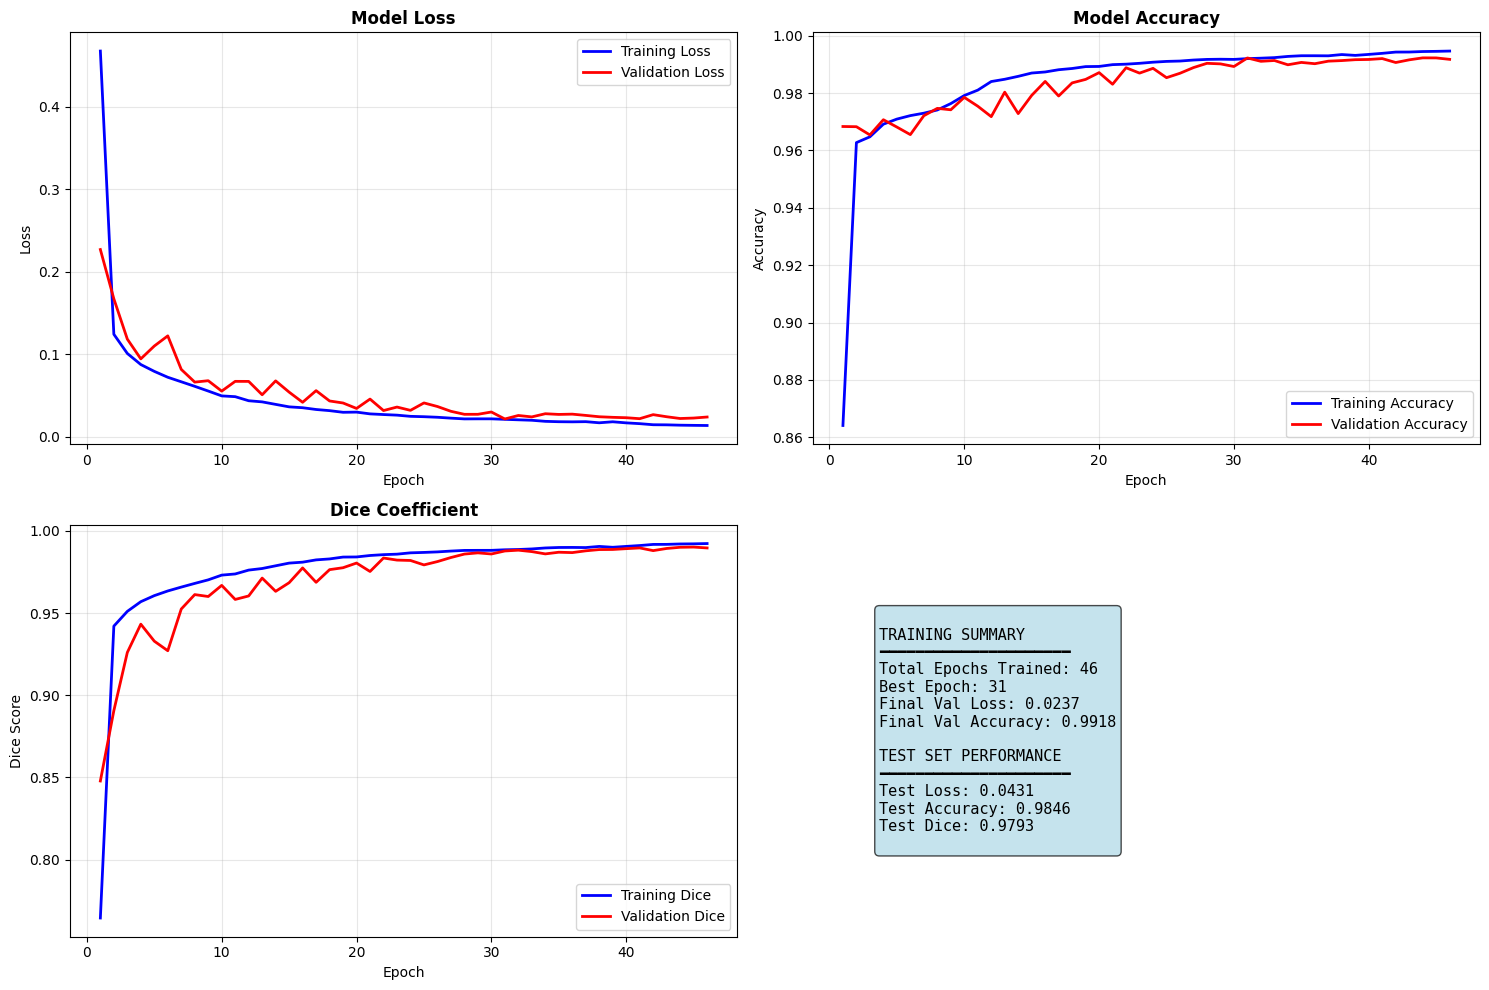

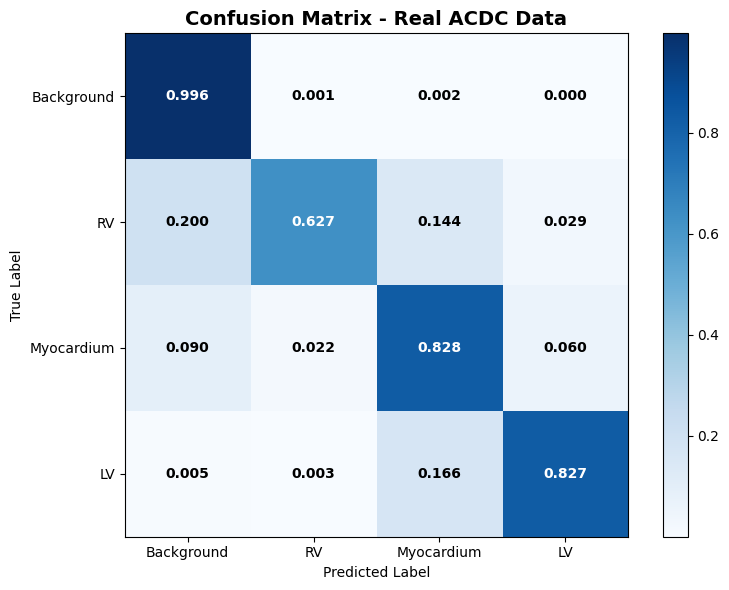

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs_range = range(1, len(history.history['loss']) + 1)

# Loss
axes[0, 0].plot(epochs_range, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
axes[0, 0].plot(epochs_range, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(epochs_range, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
axes[0, 1].plot(epochs_range, history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
axes[0, 1].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Dice Coefficient
axes[1, 0].plot(epochs_range, history.history['sparse_dice_coefficient'], 'b-',
                label='Training Dice', linewidth=2)
axes[1, 0].plot(epochs_range, history.history['val_sparse_dice_coefficient'], 'r-',
                label='Validation Dice', linewidth=2)
axes[1, 0].set_title('Dice Coefficient', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Dice Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Training summary
axes[1, 1].axis('off')
summary_text = f"""
TRAINING SUMMARY
━━━━━━━━━━━━━━━━━━━━━
Total Epochs Trained: {len(epochs_range)}
Best Epoch: {np.argmin(history.history['val_loss']) + 1}
Final Val Loss: {history.history['val_loss'][-1]:.4f}
Final Val Accuracy: {history.history['val_accuracy'][-1]:.4f}

TEST SET PERFORMANCE
━━━━━━━━━━━━━━━━━━━━━
Test Loss: {test_loss:.4f}
Test Accuracy: {test_accuracy:.4f}
Test Dice: {test_dice:.4f}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7),
                verticalalignment='center')

plt.tight_layout()
plt.show()

# ========================================================================
# STEP 10: CONFUSION MATRIX
# ========================================================================

y_pred_probs = best_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=-1)

y_true_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

cm = confusion_matrix(y_true_flat, y_pred_flat)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Background', 'RV', 'Myocardium', 'LV']

plt.figure(figsize=(8, 6))
im = plt.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix - Real ACDC Data', fontsize=14, fontweight='bold')
plt.colorbar(im)

thresh = cm_normalized.max() / 2.
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(j, i, f'{cm_normalized[i, j]:.3f}',
                horizontalalignment="center",
                verticalalignment="center",
                color="white" if cm_normalized[i, j] > thresh else "black",
                fontweight='bold')

plt.xticks(range(len(class_names)), class_names)
plt.yticks(range(len(class_names)), class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [ ]:
# PER-CLASS METRICS

print("\n" + "="*60)
print("📊 PER-CLASS METRICS")
print("="*60)
print(classification_report(y_true_flat, y_pred_flat,
                            target_names=class_names, digits=4))




📊 PER-CLASS METRICS
              precision    recall  f1-score   support

  Background     0.9944    0.9963    0.9953  28102089
          RV     0.9131    0.6269    0.7434    649282
  Myocardium     0.5438    0.8280    0.6565    305897
          LV     0.8599    0.8271    0.8432    302860

    accuracy                         0.9846  29360128
   macro avg     0.8278    0.8196    0.8096  29360128
weighted avg     0.9865    0.9846    0.9847  29360128



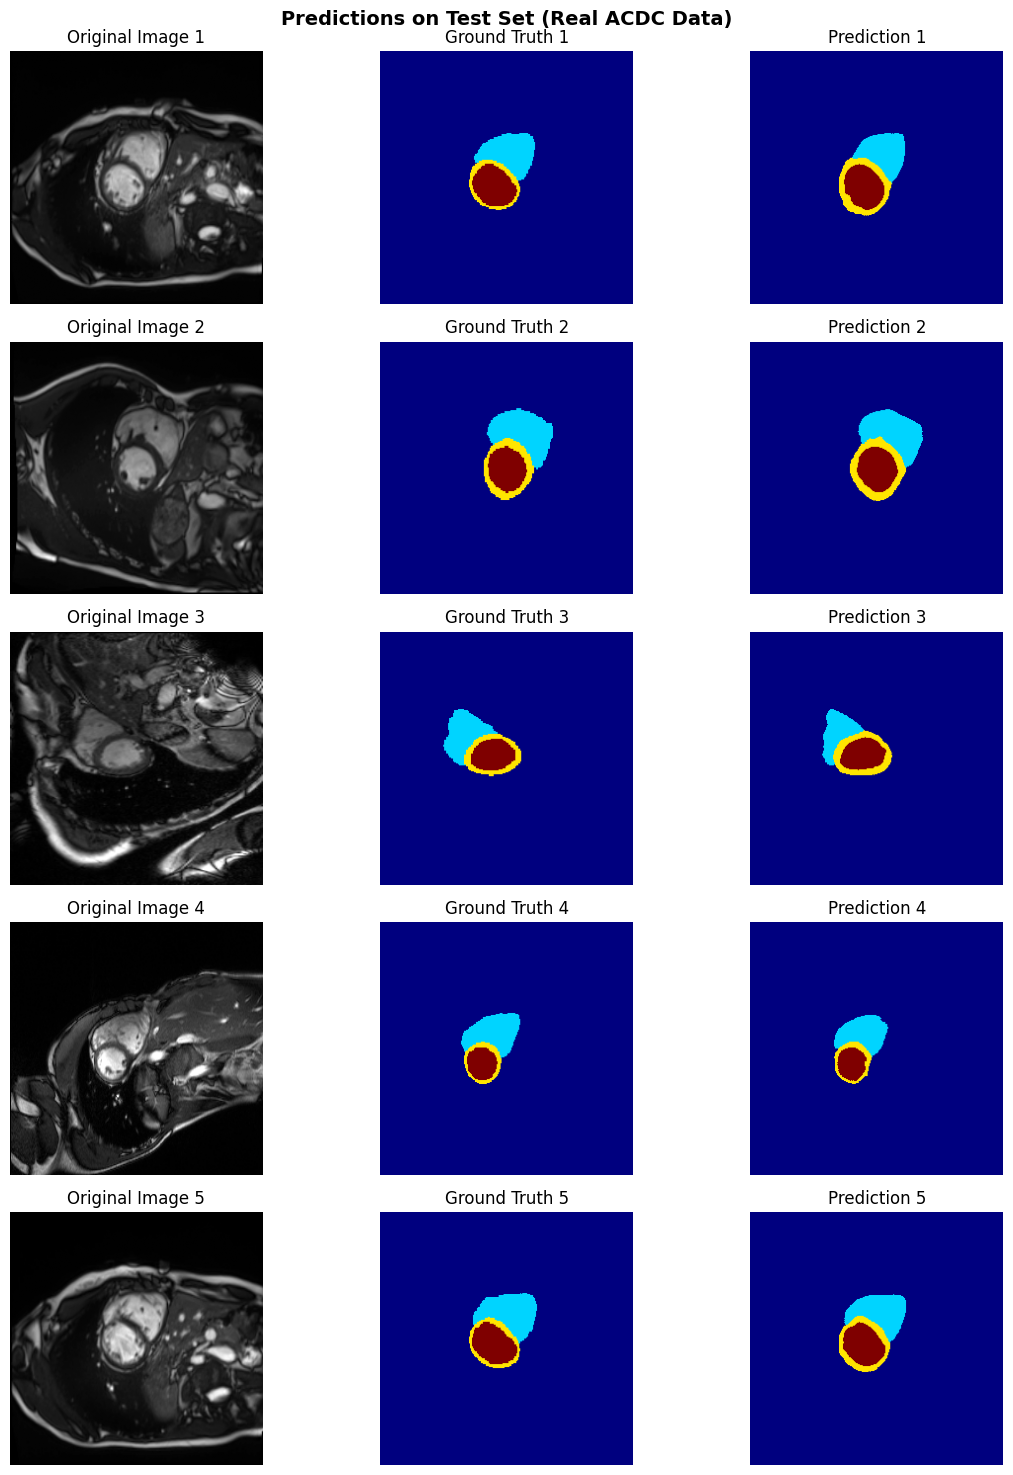


✅ TRAINING COMPLETE - REAL ACDC DATA
Model saved as: ./best_cardiac_model.h5
Training log saved as: ./training_log.csv


In [ ]:
fig, axes = plt.subplots(5, 3, figsize=(12, 15))
fig.suptitle('Predictions on Test Set (Real ACDC Data)', fontweight='bold', fontsize=14)

test_indices = np.random.choice(len(X_test), 5, replace=False)

for idx, test_idx in enumerate(test_indices):
    # Original image
    axes[idx, 0].imshow(X_test[test_idx].squeeze(), cmap='gray')
    axes[idx, 0].set_title(f'Original Image {idx+1}')
    axes[idx, 0].axis('off')

    # Ground truth mask
    axes[idx, 1].imshow(y_test[test_idx], cmap='jet')
    axes[idx, 1].set_title(f'Ground Truth {idx+1}')
    axes[idx, 1].axis('off')

    # Predicted mask
    pred_mask = y_pred[test_indices[idx]]
    axes[idx, 2].imshow(pred_mask, cmap='jet')
    axes[idx, 2].set_title(f'Prediction {idx+1}')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("✅ TRAINING COMPLETE - REAL ACDC DATA")
print("="*60)
print("Model saved as: ./best_cardiac_model.h5")
print("Training log saved as: ./training_log.csv")